# Travail d'étude et de recherche : Analyse des données
### Clio Lamek M1 sciences cognitives pour l'entreprise

### 08 juin 2023


Ci-dessous sont explicitées les étapes d'analyse des données effectuées dans le cadre de mon travail d'étude et de recherche (TER), dont le thème est : "La grip force comme mesure objective de la perception de la contribution du musicien dans une performance de musique électronique". 


> Note : L’analyse présentée ici n’est pas issue des données réelles de l’expérience. Elle a pour but de présenter la méthodologie d’analyse qui sera appliquée.

N’ayant pas pu recueillir des données issues de l’expérience, nous avons utilisé ici des **données-test** de grip force de deux participants. Celles-ci sont partagées en trois catégories : maintien en continu de la cellule, maintien puis chute de la cellule, et pics créés en appuyant rapidement sur la cellule.
Le fichier CSV généré à la fin de la mesure de grip force comporte huit colonnes : les moments de la prise de mesure, les mesures de grip force dans les 6 axes (haut-bas, gauche-droite et avant-arrière), et le voltage envoyé par la carte Arduino. Concernant les mesures de grip force, nous ne nous sommes intéressés qu’à la force appliquée en z, celle-ci correspondant à la force exercée par la main pendant l’expérimentation.

# Importation des données

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import statistics

##### IMPORTATION DES DONNÉES #####

GF = abs(pd.read_csv('maintien1.csv'))
GF2 = abs(pd.read_csv('maintien2.csv'))
GFc = abs(pd.read_csv('chute1.csv'))
GFc2 = abs(pd.read_csv('chute2.csv'))
marker = abs(pd.read_csv('markers.csv', usecols=['Time (s)', 'Fz (N)', 'AI7 (V)']))

#GF, GF2 : maitien continu de la cellule ; GFc, GFc2 : maintien puis chute de la cellule ; marker : cellule déposée sur la table + triggers

## Identification des fréquences d'échantillonnage

Les données de grip force ont été enregistrées à des fréquences d'échantillonnage différentes. J'ai créé une fonction pour pouvoir les afficher.

In [15]:
donnees = [('GF', GF), ('GF2', GF2), ('GFc', GFc), ('GFc2', GFc2), ('marker', marker)]
for nom, i in donnees:
    diff_temps = i['Time (s)'].diff()  # Calcul de la différence de temps entre les échantillons
    fe = 1 / diff_temps.mean()  # Calcul de la fréquence d'échantillonnage (inverse de la moyenne des différences)
    print(f"Fréquence d'échantillonnage de {nom} : {fe} Hz")

Fréquence d'échantillonnage de GF : 500.0 Hz
Fréquence d'échantillonnage de GF2 : 500.0 Hz
Fréquence d'échantillonnage de GFc : 2000.0 Hz
Fréquence d'échantillonnage de GFc2 : 2000.0 Hz
Fréquence d'échantillonnage de marker : 500.0 Hz


# PRÉ-TRAITEMENT (pour GF et marker UNIQUEMENT)

Pour des raisons de simplification, nous ne nous sommes intéressés qu'aux données GF (maintien continu) et marker (cellule posée sur la table et données de triggers). 

## Retrait des valeurs manquantes de grip_force

In [27]:
GF = GF.dropna()
marker = marker.dropna()

## Rééchantillonnage (de 500 Hz à 200 Hz)

Nous avons constaté que les données 'GF' et 'marker' ont une fréquence d'échantillonnage à 500 Hz. Nous avons donc créé une fonction permettant de passer de 500 Hz à 200 Hz, notre fréquence-cible.

In [35]:
exemple = [('GF', GF), ('marker', marker)]

for nom, df in exemple:
    df['Time (s)'] = pd.to_datetime(df['Time (s)'], unit='s')
    df = df.set_index('Time (s)')
    nv_df = df.resample('5ms').mean() # On prend une mesure toutes les 5 millisecondes (200 Hz)
    grip_force = nv_df['Fz (N)']
#Création de nouveaux data frames 'GF_rs' et 'marker_rs', et leurs valeurs de grip force 'grip_force_GF' et 'grip_force_marker'
    nv_nom = f"{nom}_rs"
    nv_gf = f"grip_force_{nom}"
    globals()[nv_nom] = nv_df
    globals()[nv_gf] = grip_force

## Moyennes pour la baseline

N’ayant pas pu effectuer la phase de détermination de la baseline prévue dans l’expérimentation, nous avons décidé de prendre comme valeur de référence la moyenne de force exercée pendant les 200 premières millisecondes de la mesure.

In [36]:
gf_rs = [('GF', grip_force_GF), ('marker', grip_force_marker)]

for nom, i in gf_rs:
    moy = f"moyenne_{nom}"
    moyenne = statistics.mean(i[:41]) # On prend les 41 premières valeurs de grip force (jusqu'à 200 ms)
    globals()[moy] = moyenne

## Normalisation des valeurs en prenant les valeur de référence (moyenne_GF et moyenne_marker)

Après avoir choisi notre baseline, nous l'avons mise à 0. Ainsi, nous ne nous intéressons qu'aux variations.

In [37]:
GF_normal = pd.DataFrame()
GF_normal['temps'] = GF_rs.index
GF_rs.reset_index(drop=True, inplace=True)
GF_normal['grip_force'] = GF_rs['Fz (N)'] - moyenne_GF

marker_normal = pd.DataFrame()
marker_normal['temps'] = marker_rs.index
marker_rs.reset_index(drop=True, inplace=True)
marker_normal['grip_force'] = marker_rs['Fz (N)'] - moyenne_marker

## Premier plot de test

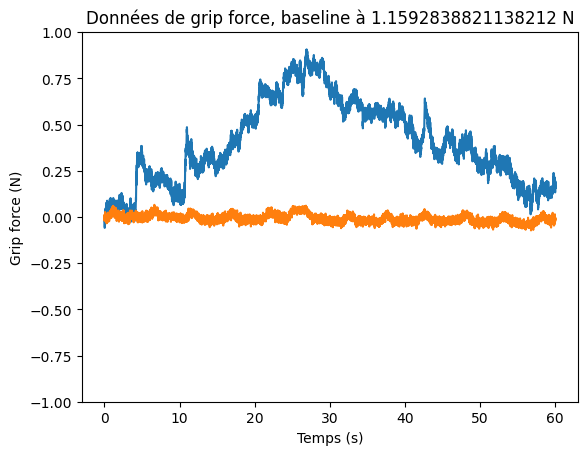

In [38]:
plt.figure()
x = np.linspace(0.0, 60.0, 12000)
plt.plot(x, GF_normal['grip_force'][:12000]) # Prendre les 12000 premières valeurs (= 60 secondes)
plt.plot(x, marker_normal['grip_force'][:12000])
plt.xlabel('Temps (s)')
plt.ylabel('Grip force (N)')
plt.title(f'Données de grip force, baseline à {moyenne_GF} N')
plt.ylim(-1, 1)
plt.show()

Ici, nous pouvons voir un premier graphique représentant les variations de force de préhension lors d'un maintien (en bleu) et quand la cellule est posée sur la table (en orange) sur une durée d'une minute.

# Plot après exclusion des données (à titre de démonstration)

Pour suivre les travaux de Nazir et al. (2017), nous avons retiré les données ayant un écart de plus de 200 mN par rapport à la baseline, et les variations de plus de 100 mN en 100 millisecondes. Si plus de 20 valeurs sont retirés pour un participant, il est complètement exclu de l’analyse.

> **Note :** Les données utilisées ici devraient être retirées de l'analyse selon ces critères. Néanmoins, nous les conserverons ici. La représentation ci-dessous permet de voir à quoi ressemblent les données après application des critères d'exclusion.

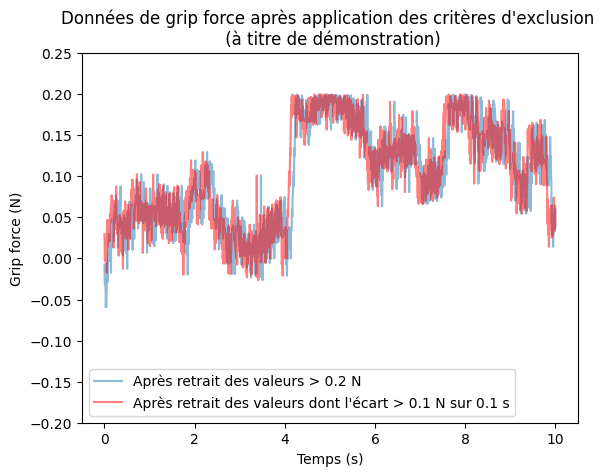

In [39]:
# Suppression des lignes de GF où les valeurs de grip force ont des variations de 0.2 N ou plus par rapport à la baseline
GF_var = GF_normal.drop(GF_normal[GF_normal['grip_force'] > 0.2].index)

# Suppression des lignes de GF où les valeurs successives ont un écart de 0.1 N ou plus en l'espace de 0.1 secondes
GF_var_2 = GF_var.set_index('temps')
window = GF_var_2['grip_force'].rolling(window=int(0.1 * 200)) # 0.1 pour la fenêtre (en secondes), et 200 pour la fréquence d'échantillonnage
GF_final = GF_var_2[window.max() - window.min() <= 0.1 * 200]


plt.figure()
x = np.linspace(0.0, 10.0, 2000)
plt.plot(x, GF_var['grip_force'][:2000], alpha=0.5, label= 'Après retrait des valeurs > 0.2 N') # Prendre les 2000 premières valeurs (= 10 secondes)
plt.plot(x, GF_final['grip_force'][:2000], color="red", alpha=0.5, label= "Après retrait des valeurs dont l'écart > 0.1 N sur 0.1 s" )
plt.xlabel('Temps (s)')
plt.ylabel('Grip force (N)')
plt.title("Données de grip force après application des critères d'exclusion \n (à titre de démonstration)")
plt.ylim(-0.2, 0.25)
plt.legend()
plt.show()

# Filtrage

Nazir et al. (2015) ont montré après une transformée de Fourier que les données pertinentes de grip force se situaient en-deça de 15 Hz. Ainsi, nous avons décidé d’appliquer un filtre passe-bas à cette limite de fréquence, d’ordre 4.

In [40]:
# Butterworth passe-bas
order = 4
cutoff_freq = 15
b, a = signal.butter(order, cutoff_freq, fs=500, btype='low')


# Appliquer le filtre Butterworth aux valeurs de grip force
donnees_filtre = [('marker', marker_normal['grip_force']), ('GF', GF_normal['grip_force'])]

for nom, i in donnees_filtre:
    gff = f"GF_filtre_{nom}"
    grip_force_filtre = signal.filtfilt(b, a, i)
    globals()[gff] = grip_force_filtre

# Données pertinentes à analyser

Parmi les données possibles à analyser, il y a la moyenne de grip force, et le maximum d'écart à la baseline. C'est ce que nous avons calculé ici.

In [50]:
# Moyenne des valeurs de grip force pour GF
meanGF = statistics.mean(grip_force_GF)
print(f"La moyenne de grip force pour les données de maintien en continu est de {meanGF}")

# Création d'un data frame avec la moyenne pour le mettre dans le plot
meanGF_df = GF_normal
meanGF_df['grip_force'] = meanGF-moyenne_GF

# Maximum d'écart à la baseline pour GF
maxGF = GF_filtre_GF.max()

print(GF_filtre_GF)
print(f"Le maximum d'écart à la baseline pour les données de maintien en continu est de {maxGF}")

La moyenne de grip force pour les données de maintien en continu est de 1.5034988169578198
[-0.00818339 -0.01123897 -0.01414989 ...  0.31466141  0.31605383
  0.31731275]
Le maximum d'écart à la baseline pour les données de maintien en continu est de 3.2840509327574106


> **Note :** les valeurs données par JupyterLab sont erronnées. En faisant tourner le script Python sur PyCharm, les valeurs sont respectivement 1.5613967631944445 et 0.8859730439920038.

# Plot final (données filtrées)

Enfin, sur ce dernier plot, nous pouvons voir les données de grip force filtrées en cas de maintien en continu (en bleu) et quand la cellule est posée sur la table (en orange). On peut également voir la moyenne de force de maitien (en rouge), ainsi que les triggers (en gris), envoyés sous forme de charge électrique par une carte Arduino.

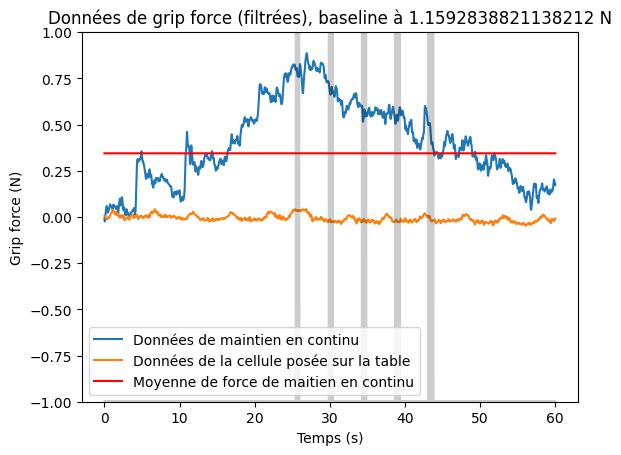

In [25]:
plt.figure()
x = np.linspace(0.0, 60.0, 12000)
plt.plot(x, GF_filtre_GF[:12000], label="Données de maintien en continu")
plt.plot(x, GF_filtre_marker[:12000], label="Données de la cellule posée sur la table")
plt.plot(x, marker_rs['AI7 (V)'][24000:36000]-1, color='black', alpha=0.2) #Pour afficher les triggers. Etant donné qu'ils apparaissaient au-delà de notre fenêtre, je les ai décalés pour qu'ils soient visibles
plt.plot(x, meanGF_df['grip_force'], color='red', label="Moyenne de force de maitien en continu")
plt.xlabel('Temps (s)')
plt.ylabel('Grip force (N)')
plt.title(f'Données de grip force (filtrées), baseline à {moyenne_GF} N')
plt.ylim(-1, 1)
plt.legend()
plt.show()

# Conclusion

À ce stade de l'analyse, aucune conclusion ne peut être faite. Il reste à identifier les valeurs de grip force associées aux triggers (ce qui n'a pas été fait car les triggers ont été décalés), et à faire les analyses statistiques adaptées pour considérer si une différence significative existe entre les valeurs de gripforce associées aux triggers et les autres valeurs. Nous avons néanmoins récolté la moyenne de force de préhension dans la condition de maintien, qui est approximativement de 1.56 N, et l'écart maximum à la valeur de référence, qui est approximativement de 0.89 N.